In [2]:
# Load Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re

# Load Data
data = pd.read_csv('train.csv')

In [ ]:
# Looking at Data
data.sample()
data.head()
data.describe()

In [5]:
bsmt = data.filter(regex = 'Bsmt.+')
bsmt.columns

data.columns[data.isnull().any()] #Basements that do not have basements are listed as N/a

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath'],
      dtype='object')

### Analyzing Null values
LotFrontage is numerical feet of street connected to property.

Alley is catergorical type of ally. NA represents no ally

MasVnrType is Mansonry Veneer type. NA represents none

Bsmt NA is no basement

Electrical has no caterigory for NA. Insepection needed.

FireplaceQu NA is no fireplace

GarageType NA is no Garage

PoolQC NA is no pool

Fence NA is no Fence

MiscFeature NA is no misc features

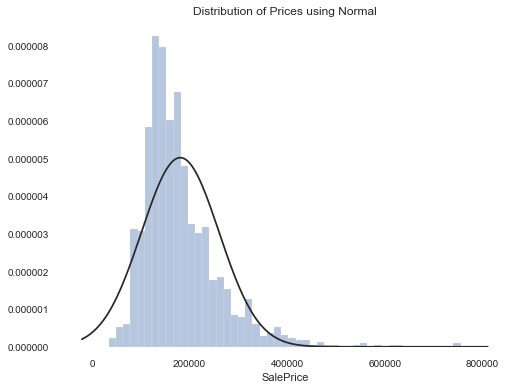

In [129]:
#Learning to recognize distribution of prices
f, axes = plt.subplots(figsize = (8,6) )
fig = sns.distplot(data.SalePrice, kde = False, fit = stats.norm).set_title('Distribution of Prices using Normal')
    # kde is a boolean for ploting a gaussian kernal density estimate
    # fit uses the probability norm function from scipy, represented in the blank line

models work better with symmetric gaussian distributions, therefore we want to get rid of the skewness.

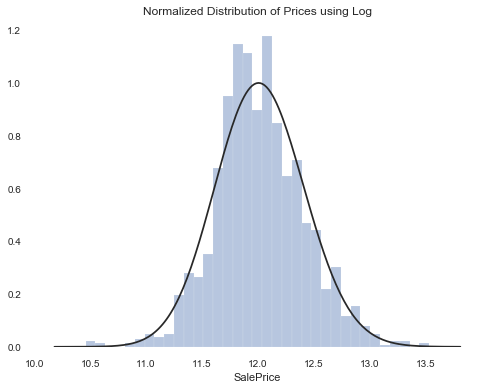

In [130]:
f,axes = plt.subplots( figsize= (8,6) )
fig = sns.distplot(np.log(data.SalePrice), kde = False, fit= stats.lognorm).set_title('Normalized Distribution of Prices using Log')

In [7]:
### Differntiate categorical and numerical values ###

data['MSSubClass'] = data['MSSubClass'].astype(object)
cat_columns = data.select_dtypes(include = ['object']).columns
cat_data = data[cat_columns]

num_columns = data.select_dtypes(exclude = ['object']).columns
num_data = data[num_columns]
num_data = num_data.drop('SalePrice', axis =1).drop('Id', axis =1)

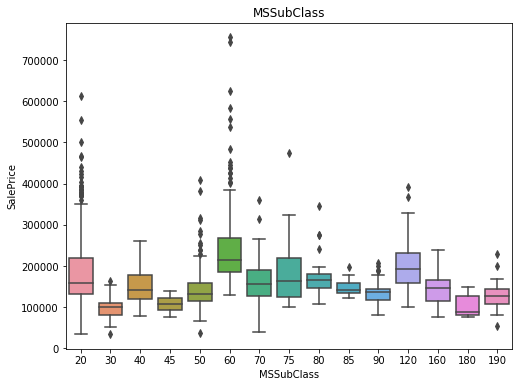

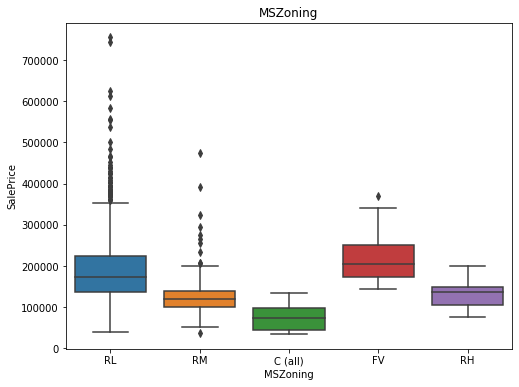

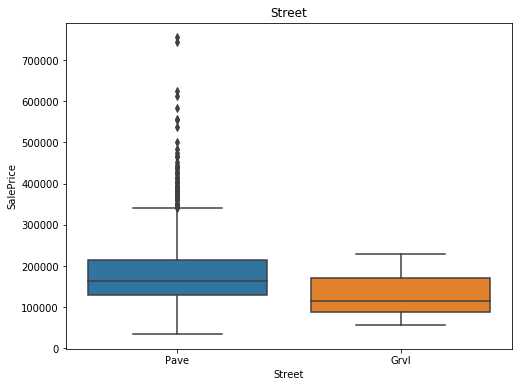

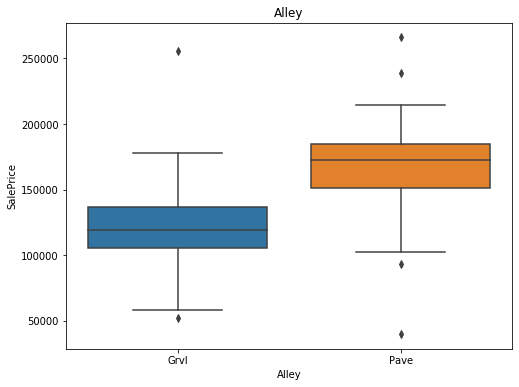

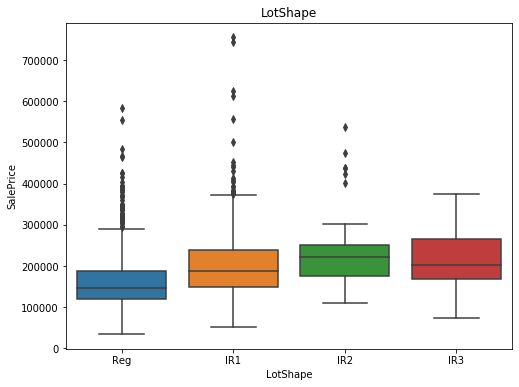

In [52]:
#Box plots for catagorial data
for colm in cat_columns[:5]:
    temp = pd.concat( [ data.SalePrice, data[colm] ], axis=1)
    f, axes = plt.subplots(figsize = (8,6) ) #figure and axies
    fig = sns.boxplot( x= colm, y= 'SalePrice', data=temp).set_title('{}'.format(colm))

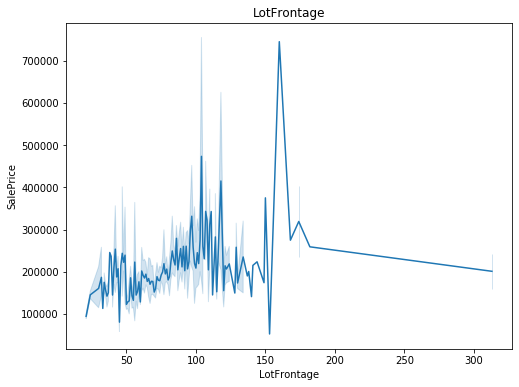

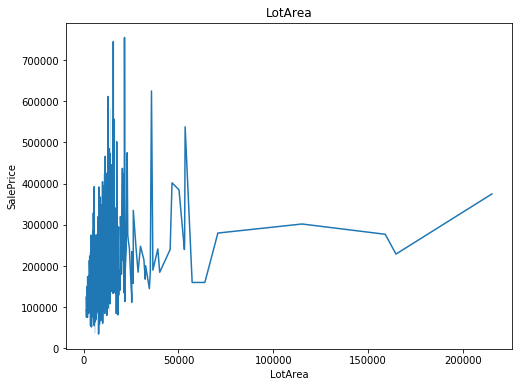

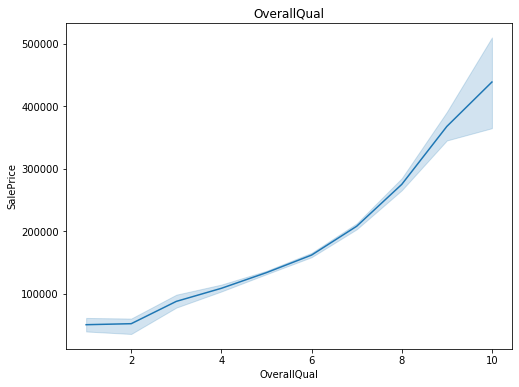

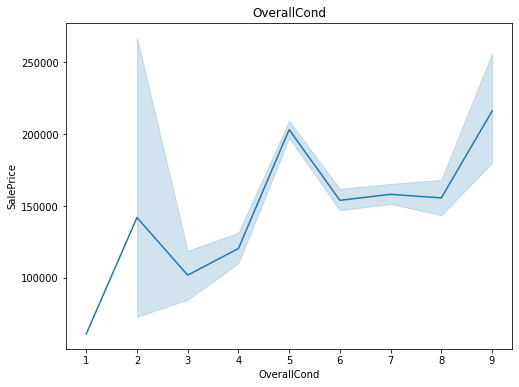

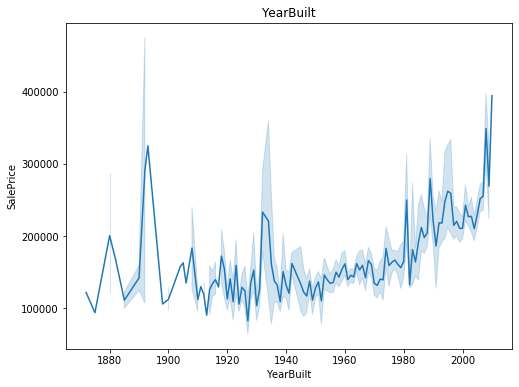

In [54]:
#Line graphs for numerical data?
for colm in num_data.columns[:5]:
    temp = pd.concat( [data.SalePrice, data[colm] ], axis =1)
    f, axes = plt.subplots(figsize = (8,6) )
    fig = sns.lineplot( x= colm, y= 'SalePrice', data = temp).set_title('{}'.format(colm))

In [26]:
# Created a function that performs the same as the loops above

def cat_box(x, y='SalePrice'):
    '''
    Call x as a string of the desired column name.
    Creates a box plot of the desired column to the Sales Price. This is adjustable by calling y.
    Displays null values with 0
    '''
    t = data[x]
    t = t.fillna(0)
    temp = pd.concat( [ data[y], t ], axis =1)
    f, axes = plt.subplots( figsize =(8,6) )
    fig = sns.boxplot( x = x, y = y, data = temp).set_title('{}'.format(x))
    
def num_graph(x, y='SalePrice', plot='line'):
    '''
    Call x as a string of the desired column name.
    Creates a graph of the desired column to Sales Price. This is adjustable by calling y
    
    Plot types: line, scatter, trend
    '''
    temp = pd.concat( [ data[y],data[x], ], axis=1)
    f, axes = plt.subplots( figsize = (8,6) )
    
    if plot =='line':
        fig = sns.lineplot( x=x, y=y, data=temp).set_title('{}'.format(x))
    elif plot == 'scatter':
        fig = sns.scatterplot( x=x, y=y, data=temp).set_title('{}'.format(x))
    else:
        raise Exception('plot not set to line or scatter')

[nan 'Shed' 'Gar2' 'Othr' 'TenC']


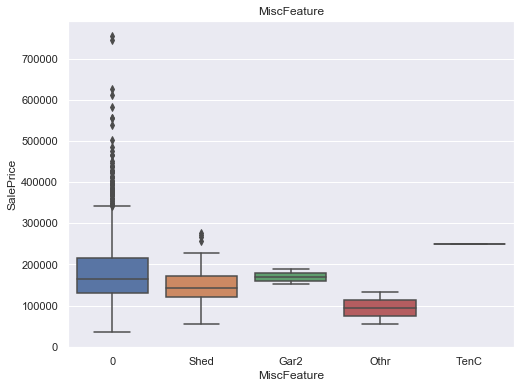

In [27]:
print(data.MiscFeature.unique())
cat_box('MiscFeature')

Comparing data through correlation matrix

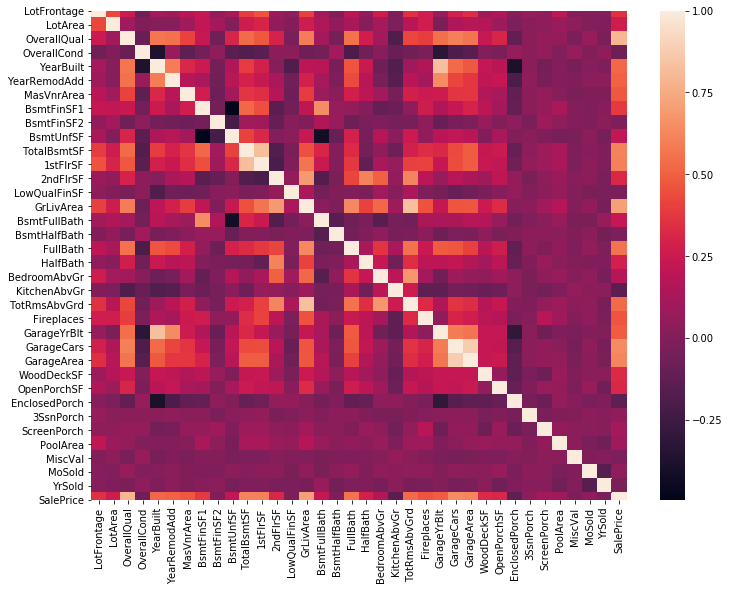

In [11]:
#Numerical correlation
corr_data = pd.concat( [num_data, data.SalePrice], axis=1)
raw_corr = corr_data.corr()
f, axes = plt.subplots(figsize = (12,9))
sns.heatmap(raw_corr)

The correlation matrix above has too many columns that makes it visually confusing. Therefore we need to identify the columns that are not useful. Some of the columns can become dummified

In [136]:
num_data_cnt = num_data.agg(["count",'size','nunique']).T #size includes na values
num_data_cnt.head()

,count,size,nunique
LotFrontage,1201,1460,110
LotArea,1460,1460,1073
OverallQual,1460,1460,10
OverallCond,1460,1460,9
YearBuilt,1460,1460,112


In [135]:
cat_data_cnt = cat_data.agg(['count','size','nunique']).T
cat_data_cnt.head()

,count,size,nunique
MSSubClass,1460,1460,15
MSZoning,1460,1460,5
Street,1460,1460,2
Alley,91,1460,2
LotShape,1460,1460,4


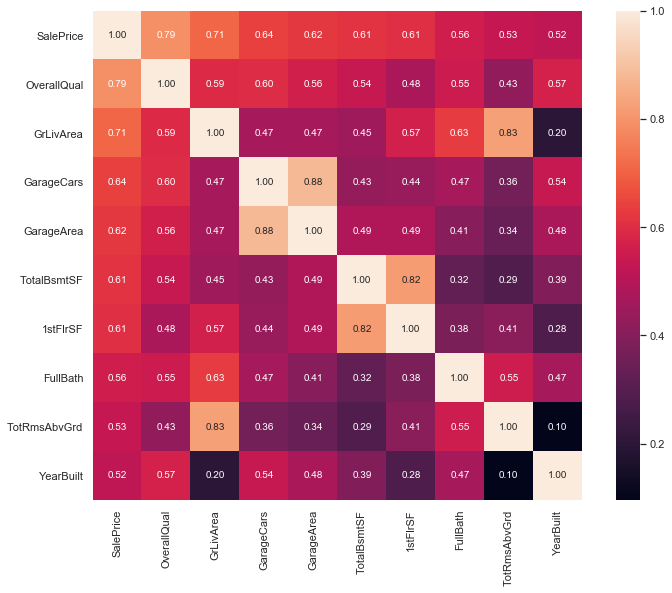

In [86]:
colm_amt = 10
cols_corr = raw_corr.nlargest(colm_amt,'SalePrice')['SalePrice'].index #Gets list of highest correlations

corr_mat_sales = np.corrcoef(data[cols_corr].values.T) #Gets pearson correlation coefficient from traversed values of the columns
sns.set(font_scale = 1)
f, axes = plt.subplots(figsize = (12,9))
hm = sns.heatmap(corr_mat_sales, 
                 cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size':10},
                 yticklabels = cols_corr.values,
                 xticklabels = cols_corr.values
                )
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [91]:
def data_type_check(colm, box=False):
    '''
    Function designed to investigate if a column is negligible.
    Set box to true for box plot. Plots only if the unique values are at or below 10.
    '''
    ratio = data[colm].count()/data[colm].size
    print('=*'*5, colm,'=*'*15, '\n',
          'Ratio between count and size: {}'.format(ratio),'\n',
          'Total number of 0\'s:', len(data[colm].loc[data[colm]==0,])
         )
    if len(data[colm].unique() ) <=50:
        print('{} unique values:'.format(colm), data[colm].unique() )
        if (len(data[colm].unique() ) <= 10) & (box==True):
            cat_box(colm)
    else:
        print('{} has over 50 unique values'.format(colm) )

In [92]:
# Loop an analysis of columns
for colm in data.columns:
    data_type_check(colm)

=*=*=*=*=* Id =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
Id has over 50 unique values
=*=*=*=*=* MSSubClass =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
MSSubClass unique values: [60 20 70 50 190 45 90 120 30 85 80 160 75 180 40]
=*=*=*=*=* MSZoning =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
MSZoning unique values: ['RL' 'RM' 'C (all)' 'FV' 'RH']
=*=*=*=*=* LotFrontage =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 0.8226027397260274 
 Total number of 0's: 0
LotFrontage has over 50 unique values
=*=*=*=*=* LotArea =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
LotArea has over 50 unique values
=*=*=*=*=* Street =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
Street unique values: ['Pave' 'Grvl']
=*=*=*=*=* Alley =*=*=*=*=*=*=*=*=*=*=*=*=*=*

MoSold unique values: [ 2  5  9 12 10  8 11  4  1  7  3  6]
=*=*=*=*=* YrSold =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
YrSold unique values: [2008 2007 2006 2009 2010]
=*=*=*=*=* SaleType =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
SaleType unique values: ['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']
=*=*=*=*=* SaleCondition =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
SaleCondition unique values: ['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']
=*=*=*=*=* SalePrice =*=*=*=*=*=*=*=*=*=*=*=*=*=*=* 
 Ratio between count and size: 1.0 
 Total number of 0's: 0
SalePrice has over 50 unique values


In [102]:
# Create a detailed report about data using Pandas Profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_file(output_file="Boston_housing_data_report.html")

## Columns that should be removed/adjusted from feature list

- **Street** There are only 6 rows of gravel out of 1460. Ratio is 0.4% **drop**
- **Alley** 90 rows with Alleys. Ratio 6.2% between alleys to overall. **drop**
- **LotShape** combine IR2 and IR3 together because there are only 41 and 10 rows respectively. **adjust**
- **Utilites** there is only 1 row with no sewage. **drop**
- **Landslope** combining moderate slope and Severe slope into one because low amount of rows and little difference when compared to Salesprice. **adjust**
- **Condition2** Too close with Condition1, but 99% of observations are Normal so not much predictive power for the other features. **drop**
- **Bsmt** Basement types; after imputing the missing values for the Square Footage of Type 1 and Type 2, we deduced that only BsmtFinSF1 and TotalBsmtSF are significant predictors out of all the NUMERIC basement variables.
    - This shows that BsmtFinSF2 is not as significant in predicting the price as the P-value is significantly low when removing SF1 from the model or when working with the full model. BsmtFinSF1 is significant in all the variations of the model. Imputed a total finished SF of the basement and ran the model but could not find it to be of significance. **BsmtUnfSF did not** seem to be a good predictor; likely because of multicollinearity; recommend  we not use it for our model. YearBuilt, GarageArea, LotArea, BsmtFinSF1, and TotalBsmtSF are all significant
- **Heating** 1428 rows are labeled as GasA. Heating is essential in housing, this catagory will not drive sale prices. **drop**
- **HeatingQC** Bin poor (1), fair (49), good (241) into one. **adjust**
- **Centeral Air** 1365 rows have Yes, others are no. **drop**
- **Electrical** 1334 rows are SBrkr. Electrcity is essential in housing, this catagory will not drive sale prices. **drop** Note: There is 1 Na value.
- **FirstFlrSF** ID 1299 has an abnomrally large area for low sales prices. Team has addressed this row, currently not enough rationale to remove the outlier.
- **SecondFlrSF** 56.8% of the data are 0's, many of the houses do not have a second floor. This is an issue because locations with second floor shows an impact to sale price. The zero's will skew the regression. To appoarch this issue we will **create a new column** SecondFlr with 0/1 values.
- **LowQualFinSF** 1434/1460 listed as zeros, after comparing the 0 values and non-0 values to SalePrices, there weren't large noticing **drop**.
- **Baths** combine and drop BsmtFullBath, BsmtHalfBath, FullBath, HalfBath to **create** a new column **TotalBaths**
- **BedroomAbGr** Number of Bedrooms above grade (does not include bathrooms), Numerical
- **KitchenAbGr** Number of Kitchens above grade. 4 unique values, 1392 rows are 1. **drop**
- **KitchenQual** 4 unique catagories. Left to be **dummified**.
- **TotRmsAbvGrd** Total number of rooms. Numerical.
- **Functional** 7 unique catagories, 1360/1460 are listed as typ. Looking at a boxplot between Functional and SalePrice, the difference between columns other than typ can be group together. There is not enough rationale to drop this column. **Adjust** the column to 1 - typ 0 - damaged
- **Fireplaces** Number of fireplaces
- **FireplaceQu**  Catagorical values with the ratio betwen non-zero values and total rows is 0.5. Non-zero values can be dummified. **Adjust** the column to replace Nan  to **None**
- **GarageType** 81 rows as NA, no garage. Catagorical can be dummified.
- **GarageYrBlt** 81 0's. Data is in years. **GarageFinish** Catagorical. **GarageCars** Numerical. **GarageArea** Numerical. **GarageQual** 1311 rows are TA. **GarageCond** 1326 rows are TA. **PavedDrive** 1340 Y (yes).
    - Combine WoodDEckSF, OpenPorchSF, EnclosedPorced, 3SsnPorch, ScreenPorch into 1 column **PorchSF** . **WoodDeckSF** should be removed/adjusted because there are 761/1460 0's. **OpenPorchSF** should be removed/adjusted because there are 656/1460 0's. **EnclosedPorch** should be removed/adjusted because there are 1252/1460 0's. **3SsnPorch** should be removed/adjusted because there are 1436/1460 0's. **ScreenPorch** should be removed/adjusted because there are 1344/1460 0's
- **Pool** 0/1 value using poolarea and poolqc **PoolArea** should be removed because there are 1453/1460 0's. **PoolQc** should be removed because ratio between non-zero values and total rows is 0.04
- **Fence** should be removed because the column only displays fence quality, 281/1460 has Fence quality. Fence quality differences doesn't show large impact to SalePrice. **Adjust** Fence to 0/1.
- **MiscFeature** should be **adjusted** to 0/1 because there are only 54 rows with values. However, **MiscVal** list the value 
- **MoSold** displays the month when the house was sold. **ordinal**
- **YrSold** displays the year when the house was sold. Column only has 5 years. **ordinal**

In [231]:
df = data.copy()
drop_col = ['Id','Street','Alley','Utilities','Condition2','Heating','CentralAir',
            'Electrical','LowQualFinSF','KitchenAbvGr','PoolQC']
df = df.drop(drop_col, axis= 1)

#Adjust LotShape to change IR 3 into IR 2
df.LotShape = df.LotShape.str.replace('IR3', 'IR2')
#Adjust LandSlope to change Sev into Mod
df.LandSlope = df.LandSlope.str.replace('Sev','Mod')
#Adjust HeatingQC to change po and fa to Gd
df.HeatingQC = ['Gd' if val in ['Fa','Po'] else val for val in df.HeatingQC.values]
#Basement: Impute BsmtFinSF1 and BsmtFinSF2, drop BsmtUnF


#Create column Secondflr to confirm second fl
df['Secondflr'] = [1 if val > 0 else 0 for val in df['2ndFlrSF'].values ]
#Combine Bathrooms
df.TotalBath = df.BsmtFullBath + df.FullBath + 0.5*(df.BsmtHalfBath + df.HalfBath)
drop_bath = ['BsmtFullBath','FullBath','BsmtHalfBath','HalfBath']
df = df.drop(drop_bath, axis=1)
#Change Functional to 0/1
df.Functional = [1 if val == 'Typ' else 0 for val in df.Functional.values ]
#Combine Porch Area
porch = ['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']
df['PorchSF'] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch
df = df.drop(porch, axis=1)
#Change Pool to 0/1
df['PoolCheck'] = [1 if val!=0 else 0 for val in df.PoolArea.values]
#Change Fence to 0/1
df['FenceCheck'] = [1 if val!=0 else 0 for val in df.Fence.values]
df = df.drop(['Fence'], axis=1)

#Dummyify columns
    #KitchenQual #drops "EX"
    #FireplaceQu #drops "Ex"
    #GarageType #2Types dropped
dummy = df.select_dtypes(include = ['object']).columns
#dummy = ['MSZoning','LotShape','LandSlope','LandContour','LotConfig','LandSlope'
#         'KitchenQual','FireplaceQu','GarageType','GarageFinish',
#         'GarageQual','GarageCond','PavedDrive','MiscFeature',
#        'MSSubType','SaleCondition']
for col in dummy:
    if df[col].isna().any()==True:
        temp = pd.get_dummies(df[col],prefix = col, dummy_na=True, drop_first= True)
    else:
        temp = pd.get_dummies(df[col],prefix =col, drop_first= True)
    df = pd.concat([df,temp],axis=1)
df=df.drop(dummy, axis=1)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleType_WD', 'SaleCondition_FV', 'SaleCondition_RH',
       'SaleCondition_RL', 'SaleCondition_RM'],
      dtype='object', length=217)

In [235]:
print(dummy)

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')


## IGNORE: Columns that should be grouped into one
**Lot** group LotFrontage, LotArea, LotShape, LotConfig

**Condition** group Condition1, Condition2

**OverallGrade** OverallQualm, OverallCond

**Roof** Roofstyle, RoofMat1

**Exterior** Exterior1st, Exterior2nd

**ExteriorGrade** ExterQual, ExterCond

**BasementGrade** BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSf2, BsmtUnfSF,
TotalBsmtSF

**TemperatureControl** Heating, HeatingQC, CentralAir

**Baths** BsmtFullBath, BsmtHalfBath, FullBath, HalfBath

**Fireplace** Fireplaces, FireplaceQu

**GarageGrade** GarageType, GarageYrBlt, GarageFinish, GarageCArs, GarageArea, GarageQual, GarageCond, PavedDrive

**Porch** WoodDEckSF, OpenPorchSF, EnclosedPorced, 3SsnPorch, ScreenPorch

**Masonry** MasVnrType, MasVnrArea

#### Removed but consider
**Porch** 0/1 value because high graded porch will impact price

**Pool** 0/1 value using poolarea and poolqc

Numeric catagorical columns: 'MSSubClass','YrSold', 'MoSold'